In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
sns.set()

In [2]:
import pkg_resources
import types


def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split('.')[0]
        elif isinstance(val, type):
            name = val.__module__.split('.')[0]
        poorly_named_packages = {'PIL': 'Pillow', 'sklearn': 'scikit-learn'}
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
        yield name


imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != 'pip':
        requirements.append((m.project_name, m.version))

for r in requirements:
    print('{}=={}'.format(*r))

matplotlib==3.8.3
numpy==1.26.4
pandas==1.5.3
seaborn==0.12.2


/tmp/ipykernel_26056/3708299036.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [3]:
def get_state(data, t, n):
    d = t - n + 1
    block = data[d : t + 1] if d >= 0 else -d * [data[0]] + data[0 : t + 1]
    res = []
    for i in range(n - 1):
        res.append(block[i + 1] - block[i])
    return np.array([res])

TSLA Time Period: **Mar 23, 2018 - Mar 23, 2019**

In [4]:
df = pd.read_csv('../dataset/MSFT.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.061378,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063570,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064667,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.063022,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061926,47894400


In [5]:
close = df.Close.values.tolist()
window_size = 30
skip = 1
l = len(close) - 1

In [6]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(layer_size, 1),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        buy = np.dot(feed, self.weights[2])
        return decision, buy

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [7]:
class Agent:

    POPULATION_SIZE = 15
    SIGMA = 0.1
    LEARNING_RATE = 0.03

    def __init__(self, model, money, max_buy, max_sell):
        self.model = model
        self.initial_money = money
        self.max_buy = max_buy
        self.max_sell = max_sell
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision, buy = self.model.predict(np.array(sequence))
        return np.argmax(decision[0]), int(buy[0])

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = get_state(close, 0, window_size + 1)
        inventory = []
        quantity = 0
        for t in range(0, l, skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, window_size + 1)
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            elif action == 2 and len(inventory) > 0:
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell

            state = next_state
        return ((initial_money - starting_money) / starting_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self.initial_money
        state = get_state(close, 0, window_size + 1)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        for t in range(0, l, skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, window_size + 1)
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
                states_buy.append(t)
                print(
                    'day %d: buy %d units at price %f, total balance %f'
                    % (t, buy_units, total_buy, initial_money)
                )
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                if sell_units < 1:
                    continue
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
                states_sell.append(t)
                try:
                    invest = ((total_sell - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (t, sell_units, total_sell, invest, initial_money)
                )
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        print(
            '\ntotal gained %f, total investment %f %%'
            % (initial_money - starting_money, invest)
        )
        plt.figure(figsize = (20, 10))
        plt.plot(close, label = 'true close', c = 'g')
        plt.plot(
            close, 'X', label = 'predict buy', markevery = states_buy, c = 'b'
        )
        plt.plot(
            close, 'o', label = 'predict sell', markevery = states_sell, c = 'r'
        )
        plt.legend()
        plt.show()

In [8]:
model = Model(window_size, 500, 3)
agent = Agent(model, 10000, 5, 5)
agent.fit(500, 10)

/tmp/ipykernel_26056/857736872.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.argmax(decision[0]), int(buy[0])


iter 10. reward: 2866.297076
iter 20. reward: 3326.990074
iter 30. reward: 4291.248684
iter 40. reward: 3007.768402
iter 50. reward: 5033.382555
iter 60. reward: 5515.582969
iter 70. reward: 5721.796751
iter 80. reward: 6007.474210
iter 90. reward: 5907.273321
iter 100. reward: 6837.942087
iter 110. reward: 7067.364310
iter 120. reward: 7130.023799
iter 130. reward: 6835.789145
iter 140. reward: 7307.428259
iter 150. reward: 6979.250225
iter 160. reward: 6912.356902
iter 170. reward: 6979.077604
iter 180. reward: 6753.218799
iter 190. reward: 7175.811782
iter 200. reward: 6154.434218
iter 210. reward: 7316.090852
iter 220. reward: 6892.086219
iter 230. reward: 7369.344170
iter 240. reward: 7483.831221
iter 250. reward: 7215.592988
iter 260. reward: 7356.616420
iter 270. reward: 5340.717381
iter 280. reward: 7269.278423
iter 290. reward: 5264.464155
iter 300. reward: 7179.686814
iter 310. reward: 7164.373755
iter 320. reward: 7075.741429
iter 330. reward: 7616.358765
iter 340. reward: 7

/tmp/ipykernel_26056/857736872.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.argmax(decision[0]), int(buy[0])


day 0: buy 5 units at price 0.486110, total balance 9999.513890
day 1: buy 5 units at price 0.503470, total balance 9999.010420
day 2: buy 5 units at price 0.512155, total balance 9998.498265
day 3: buy 5 units at price 0.499130, total balance 9997.999135
day 4: buy 5 units at price 0.490450, total balance 9997.508685
day 5: buy 5 units at price 0.477430, total balance 9997.031255
day 6: buy 5 units at price 0.464410, total balance 9996.566845
day 7: buy 5 units at price 0.451390, total balance 9996.115455
day 8: buy 5 units at price 0.460070, total balance 9995.655385
day 9: buy 5 units at price 0.473090, total balance 9995.182295
day 10: buy 5 units at price 0.481770, total balance 9994.700525
day 11: buy 5 units at price 0.477430, total balance 9994.223095
day 12: buy 5 units at price 0.473090, total balance 9993.750005
day 13: buy 5 units at price 0.477430, total balance 9993.272575
day 14: buy 5 units at price 0.481770, total balance 9992.790805
day 15: buy 5 units at price 0.4817

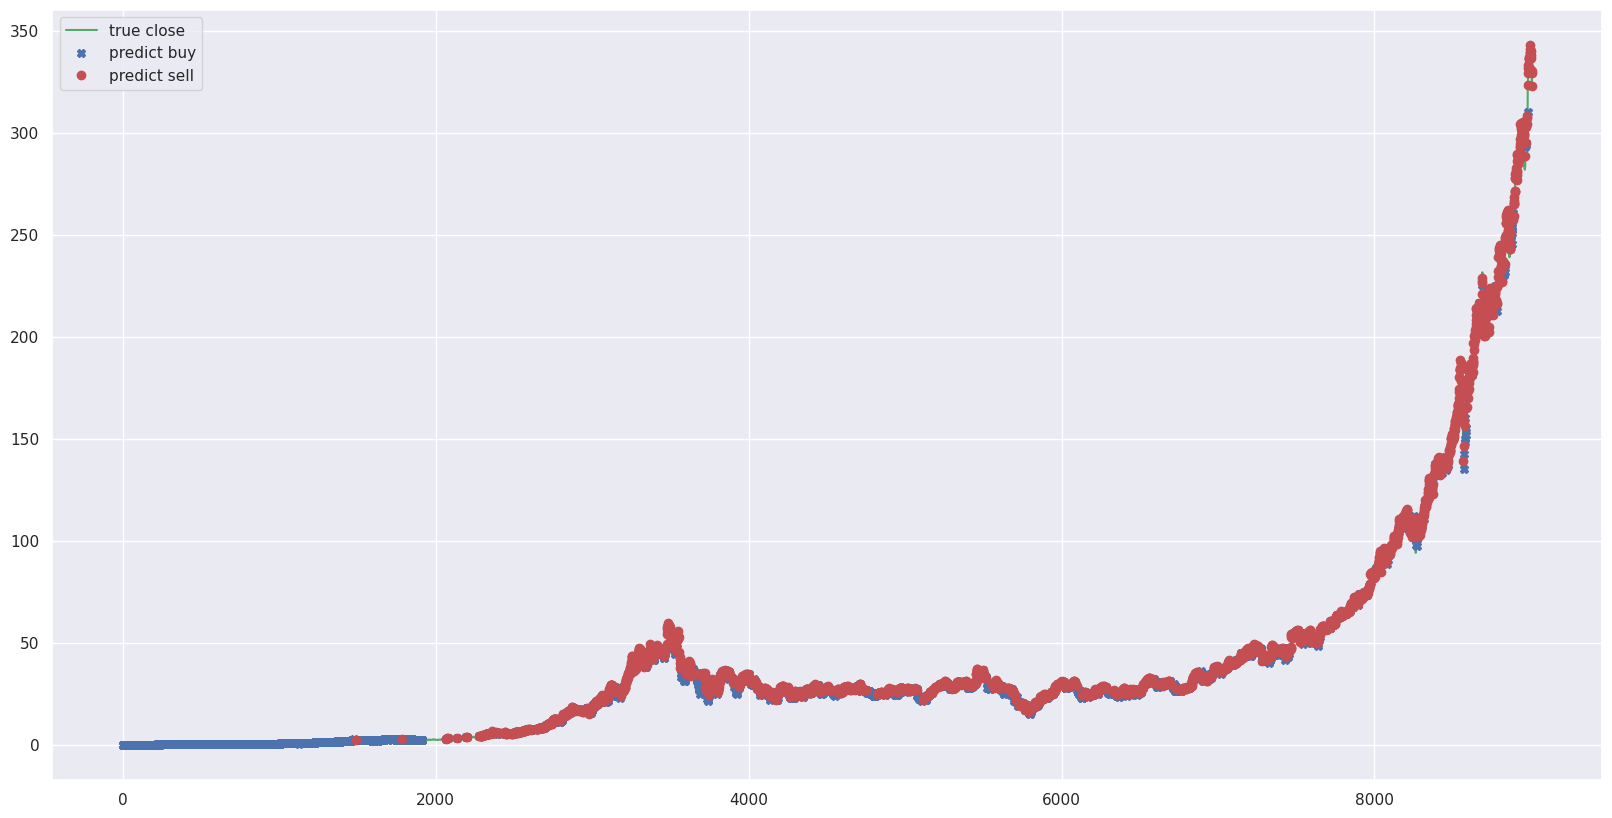

In [9]:
agent.buy()